Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Epoch 1/20, Train Loss: 0.0065, Val Loss: 0.0031
Epoch 2/20, Train Loss: 0.0032, Val Loss: 0.0030
Epoch 3/20, Train Loss: 0.0030, Val Loss: 0.0029
Epoch 4/20, Train Loss: 0.0029, Val Loss: 0.0028
Epoch 5/20, Train Loss: 0.0029, Val Loss: 0.0029
Epoch 6/20, Train Loss: 0.0029, Val Loss: 0.0028
Epoch 7/20, Train Loss: 0.0029, Val Loss: 0.0028
Epoch 8/20, Train Loss: 0.0029, Val Loss: 0.0028
Epoch 9/20, Train Loss: 0.0029, Val Loss: 0.0029
Early stopping triggered at epoch 9


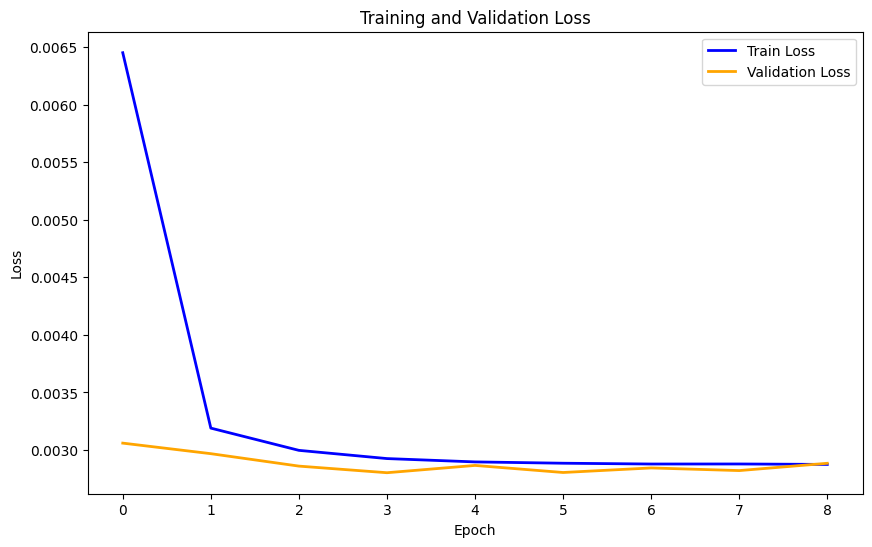

<ipython-input-2-49d1ec0028dd>:158: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/informer_best_model.pth'))


MSE: 6.2714
MAE: 1.9288
RMSE: 2.5043
Training Time: 165.29 seconds
Inference Time: 1.80 seconds


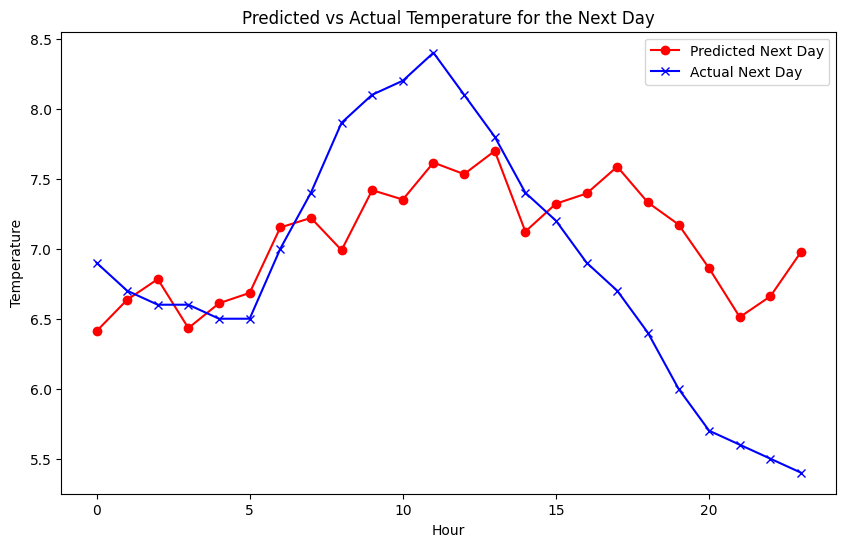

In [2]:
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Informer Model
class Informer(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, output_length):
        super(Informer, self).__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=0.1, batch_first=True),
            num_layers=num_layers
        )
        self.fc = nn.Linear(embed_dim, output_length)
        self.embed = nn.Linear(input_dim, embed_dim)

    def forward(self, x):
        x = self.embed(x)
        x = self.encoder(x)
        x = x[:, -1, :]  # Use the last time step
        return self.fc(x)

# Load data
data = pd.read_excel('/content/drive/MyDrive/data_set/train/reversed_weather_data.xlsx', index_col=0)

# Target and features
target = data['temp'].values
features = data[['temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'pres']].values

# Scale data
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

features = scaler_features.fit_transform(features)
target = scaler_target.fit_transform(target.reshape(-1, 1)).flatten()

# Hyperparameters
input_length = 24 * 7  # 1 week of hourly data
output_length = 24  # 1 day of hourly data
embed_dim = 128
num_heads = 4
num_layers = 2
batch_size = 32
learning_rate = 1e-4
epochs = 20
patience = 5

# Dataset class
class MultiFeatureDataset(torch.utils.data.Dataset):
    def __init__(self, features, target, input_length, output_length):
        self.features = features
        self.target = target
        self.input_length = input_length
        self.output_length = output_length

    def __len__(self):
        return len(self.target) - self.input_length - self.output_length + 1

    def __getitem__(self, idx):
        x = self.features[idx:idx + self.input_length]
        y = self.target[idx + self.input_length:idx + self.input_length + self.output_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Dataset and DataLoader
dataset = MultiFeatureDataset(features, target, input_length, output_length)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model, loss, optimizer
model = Informer(
    input_dim=features.shape[1],
    embed_dim=embed_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    output_length=output_length
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# Training loop with early stopping
best_loss = float('inf')
stopping_counter = 0
train_losses, val_losses = [], []
training_start_time = time.time()

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(x_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            preds = model(x_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item()

    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping logic
    if val_loss < best_loss:
        best_loss = val_loss
        stopping_counter = 0
        torch.save(model.state_dict(), '/content/drive/MyDrive/informer_best_model.pth')
    else:
        stopping_counter += 1
        if stopping_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

training_end_time = time.time()
training_duration = training_end_time - training_start_time

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='orange', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Load best model
model.load_state_dict(torch.load('/content/drive/MyDrive/informer_best_model.pth'))
model.eval()

# Evaluate model with test data
predictions, targets = [], []
inference_start_time = time.time()

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        preds = model(x_batch)
        predictions.append(preds.cpu().numpy())
        targets.append(y_batch.cpu().numpy())

inference_end_time = time.time()
inference_duration = inference_end_time - inference_start_time

# Flatten predictions and targets
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)

# Invert scaling
predictions = scaler_target.inverse_transform(predictions)
targets = scaler_target.inverse_transform(targets)

# Calculate metrics
mse = mean_squared_error(targets, predictions)
mae = mean_absolute_error(targets, predictions)
rmse = np.sqrt(mse)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Training Time: {training_duration:.2f} seconds")
print(f"Inference Time: {inference_duration:.2f} seconds")

# Predict last week
last_week_features = features[-(input_length + output_length):-output_length]
real_next_day = target[-output_length:]

last_week_features_tensor = torch.tensor(last_week_features, dtype=torch.float32).unsqueeze(0).to(device)

with torch.no_grad():
    predicted_next_day = model(last_week_features_tensor).cpu().numpy().flatten()

predicted_next_day = scaler_target.inverse_transform(predicted_next_day.reshape(-1, 1)).flatten()
real_next_day = scaler_target.inverse_transform(real_next_day.reshape(-1, 1)).flatten()

# Plot comparison of prediction and actual data
plt.figure(figsize=(10, 6))
plt.plot(predicted_next_day, label='Predicted Next Day', color='red', marker='o')
plt.plot(real_next_day, label='Actual Next Day', color='blue', marker='x')
plt.xlabel('Hour')
plt.ylabel('Temperature')
plt.title('Predicted vs Actual Temperature for the Next Day')
plt.legend()
plt.show()
